### Data preparing

In [1]:
plt.style.use('bmh')

df = pd.read_csv('data/aave_v3_ethereum.csv')#.sort_values(['user','report_month'])
# df['day_start'] = pd.to_datetime(df['day_start'].str[:10])
# df['report_month'] = pd.to_datetime(df['report_month'].str[:10])

df['start_month'] = df['day_start'].str[:7]
df['report_month'] = df['report_month'].str[:10]

# feature engineering
df['current_supply_perc'] = df.groupby('user').current_supply.apply(lambda x: x / (x.iloc[0] + 0.001))
df['current_borrow_perc'] = df.groupby('user').current_supply.apply(lambda x: x / (x.iloc[0] + 0.001))
df['report_num'] = df.groupby('user').report_month.cumcount() + 1

bins = [-np.inf, 0, 10, 1000, 10000, 100000, np.inf]
labs = ['0)0$', '1)0-10$', '2)10-1K$', '3)1K-10K$', '4)10K-100K$', '5)100K$+']
df['current_supply_cat'] = pd.cut(df['current_supply'], bins, labels = labs).astype(str)
df['amt_supply_cat'] = pd.cut(df['amt_supply'], bins, labels = labs).astype(str)

df['cnt_trnx'] = df[['cnt_supply','cnt_withdraw','cnt_borrow','cnt_repay']].sum(axis = 1)

df['current_borrow_flg'] = (df['current_borrow'] > 0).astype(int)
df['current_supply_flg'] = (df['current_supply'] > 0).astype(int)

df['amt_borrow_flg'] = (df['amt_borrow'] > 0).astype(int)
df['amt_supply_flg'] = (df['amt_supply'] > 0).astype(int)

print(df.shape)
df[-5:]

(36940, 33)


,user,day_start,report_month,cnt_tokens,cnt_tokens_supply,cnt_tokens_borrow,cnt_supply,cnt_withdraw,cnt_liquidate_supply,cnt_borrow,cnt_repay,cnt_liquidate_borrow,amt_supply,amt_withdraw,amt_liquidate_supply,amt_borrow,amt_repay,amt_liquidate_borrow,current_supply,current_borrow,interest_supply,interest_borrow,start_month,current_supply_perc,current_borrow_perc,report_num,current_supply_cat,amt_supply_cat,cnt_trnx,current_borrow_flg,current_supply_flg,amt_borrow_flg,amt_supply_flg
36935,0xfff95fbe9f34bdeff54de0c7088bb3376a446caf,2023-03-19 00:00:00.000 UTC,2023-03-31,1,1,0,1,0,0,0,0,0,1.09,0.00,0.00,0.00,0.00,0.00,1.09,0.00,0.00,0.00,2023-03,1.00,1.00,1,1)0-10$,1)0-10$,1,0,1,0,1
36936,0xfff95fbe9f34bdeff54de0c7088bb3376a446caf,2023-03-19 00:00:00.000 UTC,2023-04-30,1,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.14,0.00,0.00,0.00,2023-03,1.05,1.05,2,1)0-10$,0)0$,0,0,1,0,0
36937,0xfff95fbe9f34bdeff54de0c7088bb3376a446caf,2023-03-19 00:00:00.000 UTC,2023-05-31,1,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.12,0.00,0.00,0.00,2023-03,1.03,1.03,3,1)0-10$,0)0$,0,0,1,0,0
36938,0xfff95fbe9f34bdeff54de0c7088bb3376a446caf,2023-03-19 00:00:00.000 UTC,2023-06-30,1,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.13,0.00,0.00,0.00,2023-03,1.04,1.04,4,1)0-10$,0)0$,0,0,1,0,0
36939,0xfff95fbe9f34bdeff54de0c7088bb3376a446caf,2023-03-19 00:00:00.000 UTC,2023-07-31,1,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.12,0.00,0.00,0.00,2023-03,1.03,1.03,5,1)0-10$,0)0$,0,0,1,0,0


### Usage

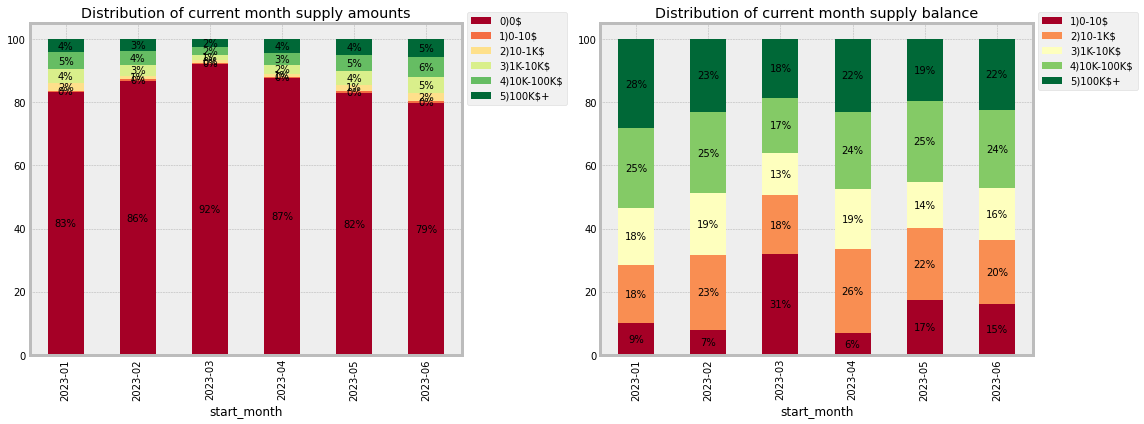

In [2]:
_, ax = plt.subplots(1,2, figsize = (16,6))

# Distribution of current month supply amounts
f0 = df.report_num > 1
f1 = df.current_supply > 0
df_st = df[f0&f1].groupby(['start_month','amt_supply_cat']).size().unstack()
df_st = 100*df_st.apply(lambda x: x/sum(x), axis = 1)
# plotting
p = df_st.plot(kind = 'bar', ax = ax[0], stacked = True, legend = False, title = 'Distribution of current month supply amounts', cmap = 'RdYlGn')
_ = p.legend(bbox_to_anchor=(1., 1.05))
for c in p.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [f'{int(v.get_height())}%' if v.get_height() > 0 else '' for v in c]   
    # remove the labels parameter if it's not needed for customized labels
    p.bar_label(c, labels=labels, label_type='center')
    
# Distribution of current month supply balance
f0 = df.report_num > 1
f1 = df.current_supply > 0
df_st = df[f0&f1].groupby(['start_month','current_supply_cat']).size().unstack()
df_st = 100*df_st.apply(lambda x: x/sum(x), axis = 1)
# plotting
p = df_st.plot(kind = 'bar', ax = ax[1], stacked = True, legend = True, title = 'Distribution of current month supply balance', cmap = 'RdYlGn')
p.legend(bbox_to_anchor=(1., 1.05))
for c in p.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [f'{int(v.get_height())}%' if v.get_height() > 0 else '' for v in c]    
    # remove the labels parameter if it's not needed for customized labels
    p.bar_label(c, labels=labels, label_type='center')
    
plt.tight_layout()

In [3]:
f00 = df.current_supply_cat != '0)0$'

In [4]:
df[f0&f00].groupby(['amt_supply_cat']).size()

amt_supply_cat
0)0$           22074
1)0-10$           76
2)10-1K$         310
3)1K-10K$        747
4)10K-100K$      942
5)100K$+         892
dtype: int64

In [5]:
# create aggregations
feats_ag = ['cnt_trnx','cnt_tokens','current_borrow','current_supply','current_supply_flg','amt_borrow_flg']

df1 = df[f0&f00].groupby(['amt_supply_cat'])[feats_ag].mean()
df1['ltv'] = df1['current_borrow'] / df1['current_supply']

df11 = df[f0&f00].groupby(['start_month'])[feats_ag].mean()
df11['ltv'] = df11['current_borrow'] / df11['current_supply']

df2 = df[f0&f00].groupby(['start_month','amt_supply_cat'])[feats_ag].mean()
df2['ltv'] = df2['current_borrow'] / df2['current_supply']

In [6]:
df1

,cnt_trnx,cnt_tokens,current_borrow,current_supply,current_supply_flg,amt_borrow_flg,ltv
amt_supply_cat,,,,,,,
0)0$,0.15,1.90,"47,583.40","237,320.49",1.00,0.04,0.20
1)0-10$,3.80,3.74,"1,046.82","7,566.74",1.00,0.20,0.14
2)10-1K$,3.28,2.78,"13,866.32","63,025.40",1.00,0.39,0.22
3)1K-10K$,3.77,2.95,"18,598.43","74,659.51",1.00,0.61,0.25
4)10K-100K$,5.34,3.21,"65,963.22","246,151.87",1.00,0.72,0.27
5)100K$+,11.57,3.33,"1,237,298.51","4,229,435.78",1.00,0.68,0.29


In [7]:
df11

,cnt_trnx,cnt_tokens,current_borrow,current_supply,current_supply_flg,amt_borrow_flg,ltv
start_month,,,,,,,
2023-01,1.28,2.14,"72,869.04","304,390.41",1.00,0.15,0.24
2023-02,0.98,2.23,"105,036.14","419,704.79",1.00,0.12,0.25
2023-03,0.54,1.88,"57,018.99","324,980.27",1.00,0.07,0.18
2023-04,1.19,1.98,"107,825.46","387,602.53",1.00,0.11,0.28
2023-05,1.29,2.21,"225,435.66","604,818.87",1.00,0.15,0.37
2023-06,1.60,2.15,"90,650.03","325,596.05",1.00,0.19,0.28


### plots

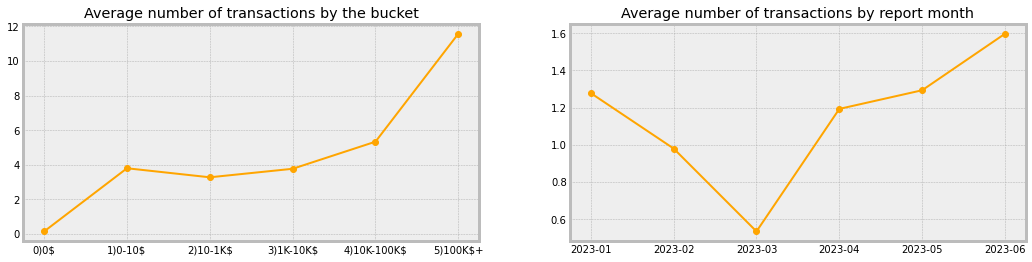

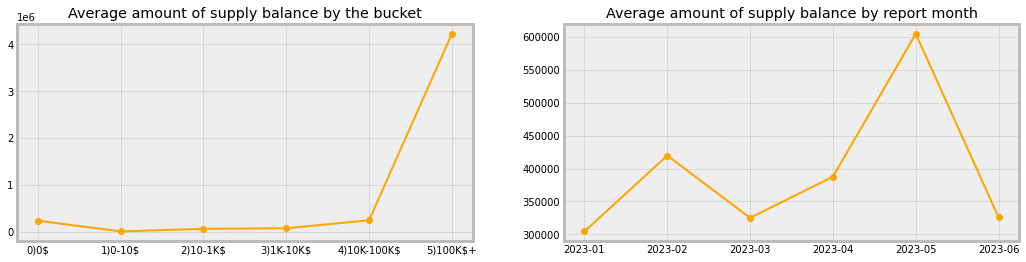

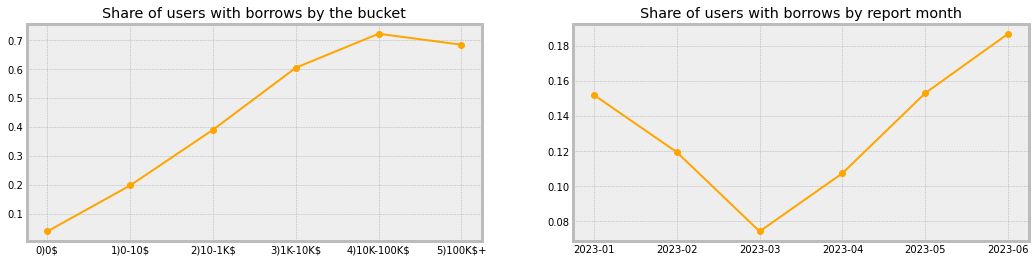

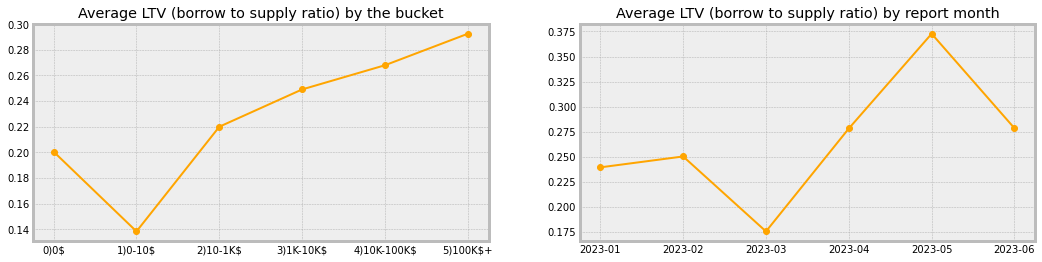

In [9]:
list_feat = [
    'cnt_trnx',
    'current_supply',
    'amt_borrow_flg',
    'ltv',
]
list_title = [
    'Average number of transactions',
    'Average amount of supply balance',
    'Share of users with borrows',
    'Average LTV (borrow to supply ratio)',
]
for feat, title in zip(list_feat, list_title):
    _, ax = plt.subplots(1,2, figsize = (16,4))#, gridspec_kw={'width_ratios': [1, 1]})
    _ = df1[feat].plot(ax = ax[0], kind = 'line', style = 'o-', xlabel = '', title = title + ' by the bucket', color = 'orange')
    _ = df11[feat].plot(ax = ax[1], kind = 'line', style = 'o-', xlabel = '', title = title + ' by report month', color = 'orange')

    # _, ax = plt.subplots(1,1, figsize = (18,6))
    # _ = df2[feat].unstack().plot(ax = ax, kind = 'line', style = 'o-', xlabel = '', title = title)